# Import library

In [195]:
import numpy as np
import pandas as pd
import pyapep as pa
import matplotlib.pyplot as plt
import pyiast

# Isotherm Data

## Key Information

In [196]:
par_ch4 = [7.79557598e+01, 9.73454365e-03, 7.53295149e-04] # Based on mol/kg vs bar
par_n2 = [1.10602315e+02, 1.62400673e-02] # Based on mol/kg vs bar

dH_list = [10.70159912, 6.48034025] ## kJ
T_ref_list = [220,180]  ## K

rho_solid = 238.77340815964 ## kg/m^3

def Lang(p_in,par):
    qtmp = par[0] * par[1]*p_in/(1+par[1]*p_in)
    return qtmp

def Quad(p_in,par):
    qtmp = par[0]*(par[1]*p_in+2*par[2]*p_in**2)/(1+par[1]*p_in + par[2]*p_in**2)
    return qtmp

def DSLa(p_in,par):
    qtmp1 = par[0]*par[2]*p_in/(1+par[2]*p_in)
    qtmp2 = par[1]*par[3]*p_in/(1+par[3]*p_in)
    qtmp_return = qtmp1 + qtmp2
    return qtmp_return

Text(0.5, 1.0, 'N2 dummy')

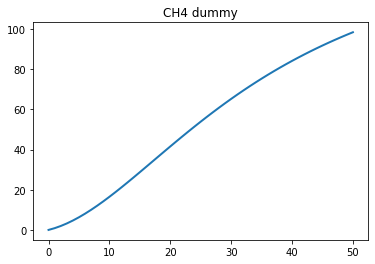

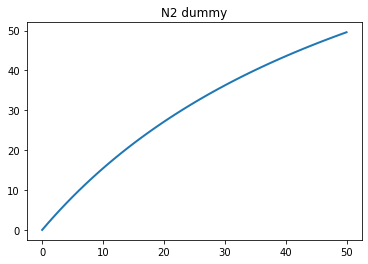

In [197]:
## CH4 Case ##
p_test = np.linspace(0,50, 51)
qch4_test = Quad(p_test,par_ch4)
di_ch4 = {'p':p_test,'q':qch4_test}
df_ch4 = pd.DataFrame(di_ch4)

plt.figure()
plt.plot(p_test,qch4_test,linewidth = 2)
plt.title('CH4 dummy')


## N2 Case ##
p_test = np.linspace(0,50, 51)
qn2_test = Lang(p_test,par_n2)
di_n2 = {'p':p_test,'q':qn2_test}
df_n2 = pd.DataFrame(di_n2)

plt.figure()
plt.plot(p_test,qn2_test,linewidth = 2)
plt.title('N2 dummy')

## Fitting with pyiast

In [198]:
iso0 = pyiast.ModelIsotherm(df_ch4,
                            loading_key='q',pressure_key = 'p',
                            model= 'Quadratic', 
                            param_guess = {
                                'M': par_ch4[0],
                                'Ka':par_ch4[1],
                                'Kb':par_ch4[2]
                                })
print(iso0.params)

iso1 = pyiast.ModelIsotherm(df_n2,
                            loading_key='q',pressure_key = 'p',
                            model= 'Langmuir', 
                            param_guess = {'M': par_n2[0],
                                           'K': par_n2[1],
                                           })
print(iso1.params)
iso_pyiast = [iso0, iso1]

{'M': 77.9557598, 'Ka': 0.00973454365, 'Kb': 0.000753295149}
{'M': 110.602315, 'K': 0.0162400673}


# Test Storage Tank Model

In [317]:
### Conditions ###

# %% Feed conditions
# Inlet conditions ?
feed_composition = [0.995,0.005]
T_inlet = 300 # K

# %% Heat capacity info
# Heat related properties (methane; nitrogen) + (zeolite)
Cp_g = np.array([40.63,29.22])  # Gas heat capacity: J/mol/K
Cp_s = 850                      # Solid heat capacity: J/kg/K
#Cp_s = 948                      # Solid heat capacity: J/kg/K

x_gas = [0.995,0.005]
T_current = [298]
#T_current = [250]
P_init = 1
P_norm = np.exp(np.array(dH_list)*1000/8.3145*(1/np.array(T_current) - 1/np.array(T_ref_list)))*x_gas*P_init
q_init_eq = pyiast.iast(P_norm,[iso0,iso1],)
print('[q_inti_1, q_init_2] = ')
print(q_init_eq)
#q_solid = [0.0,0.0]
q_solid = list(q_init_eq)

initial_variables = x_gas + q_solid + T_current


[q_inti_1, q_init_2] = 
[0.1683844  0.00164041]


In [318]:
Result_test = pa.storage_tank(feed_composition,iso_pyiast,dH_list,T_ref_list,
                              initial_variables,P_in=3, T_in = T_inlet)
Perf_test = pa.Massbal_interation(Result_test.x[0:2], Result_test.x[2],
                                  feed_composition,iso_pyiast,dH_list,T_ref_list,
                                  initial_variables,P_in=3, T_in = T_inlet)
print(Perf_test)

SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
(1919.0085635989392, array([0.33753975, 0.00181484]), 0, array([ True,  True]))


# For different pressure and temperature

## Import Feed Conditions

[156.586 156.994 157.447 157.909 158.393 158.894 159.409 159.936 160.527
 161.079 161.639 162.207 162.779 163.356 163.963 164.554 165.052 165.436
 166.023 166.511 167.001 167.493 167.987 168.482 168.979 169.477 174.539
 179.69  184.842 189.887 194.461 198.687 202.554]
[ 2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.
  9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  20.  25.
 30.  35.  40.  45.  50. ]


Text(0.5, 1.0, 'Feed Conditions After Compressor')

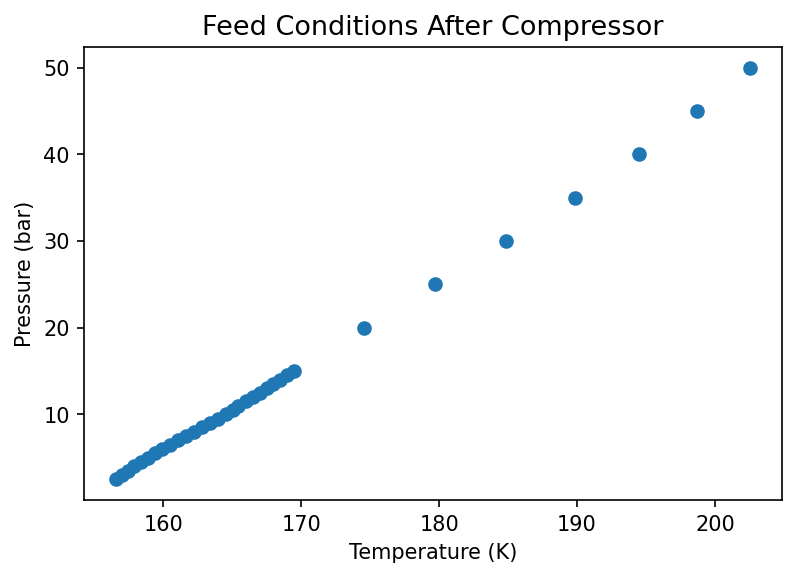

In [319]:
FC = pd.read_excel('Feed_conditions_recycle.xlsx')
Tfeed_arr = FC['T(K)'].to_numpy()
Pfeed_arr = FC['P(bar)'].to_numpy()
#Tfeed_arr = np.append(Tfeed_arr, Tfeed_arr[-1])
#Tfeed_arr = np.append(Tfeed_arr, Tfeed_arr[-1])
#Pfeed_arr = np.append(Pfeed_arr, 20)
#Pfeed_arr = np.append(Pfeed_arr, 30)
print(Tfeed_arr)
print(Pfeed_arr)

## Graph ##
plt.figure(dpi =150)
plt.plot(Tfeed_arr,Pfeed_arr, 'o')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (bar)')
plt.title('Feed Conditions After Compressor',fontsize = 13)

## Run Storage Model

In [320]:
del_M_list = []
T_fin_list = []
L = 5
A = 3.1416
epsi = 0.4
Mmolar = np.array([0.016, 0.028])       # kg/mol
M_av = np.sum(np.array(x_gas)*Mmolar)   # kg/mol
Design_spec = {'A': A, 'L':L,'rho_s':rho_solid, 'epsi':0.4}
for T_ff, P_ff in zip(Tfeed_arr, Pfeed_arr):
    Result_tmp = pa.storage_tank(feed_composition,iso_pyiast, dH_list,T_ref_list,
                                initial_variables, 
                                P_in = P_ff, T_in = T_ff,
                                Design=Design_spec)
    Perf_tmp = pa.Massbal_interation(Result_tmp.x[0:2], Result_tmp.x[2],
                                     feed_composition,iso_pyiast,
                                     dH_list,T_ref_list,
                                     initial_variables, P_in = P_ff, T_in = T_ff,
                                     Design=Design_spec)
    del_M_list.append(Perf_tmp[0])
    T_fin_list.append(Result_tmp.x[2])

SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
SHGO METHOD IS USED !!!
SHGO METHOD IS PICKED !!!
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
C:\ProgramData\Anaconda3\lib\site-packages\pyiast\isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
C:\ProgramData\Anaconda3\lib\site-packa

## Graph (Storage)

In [321]:
len(Pfeed_arr)
#len(Pfeed_arr)

33

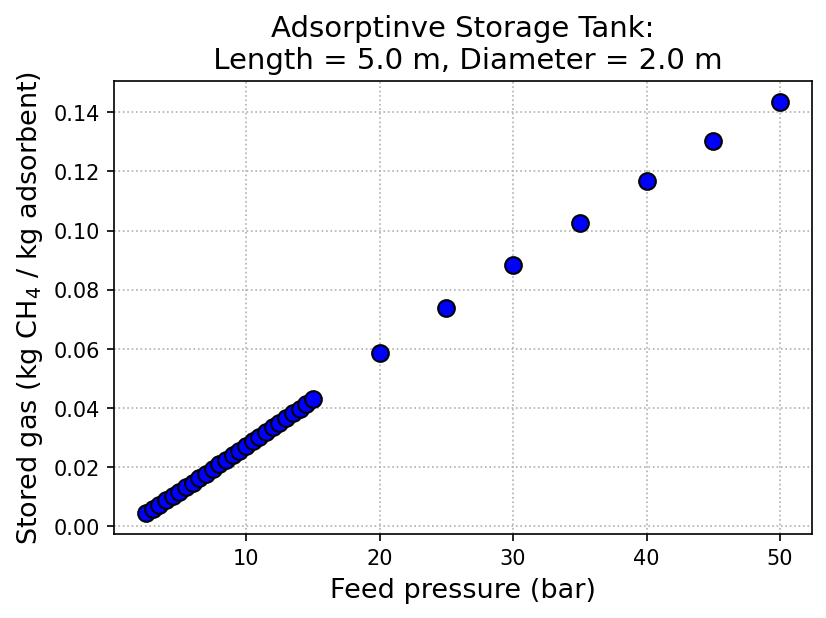

In [322]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.028])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg / (rho_solid*L*A*(1-epsi)),
         'o', color = 'k',markersize = 8, mfc = 'b')
plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Stored gas (kg CH$_{4}$ / kg adsorbent)', fontsize = 13)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

## Graph (Temperature)

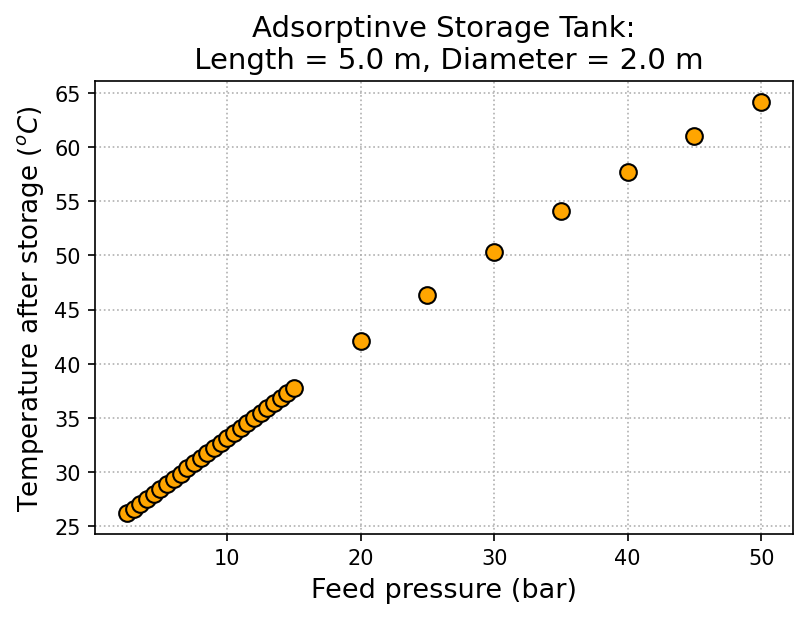

In [323]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, np.array(T_fin_list) + T_current[0] - 273.15,
         'o', color = 'k',markersize = 8,mfc = 'orange')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('Temperature after storage ($^{o}C$)', fontsize = 12.5)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

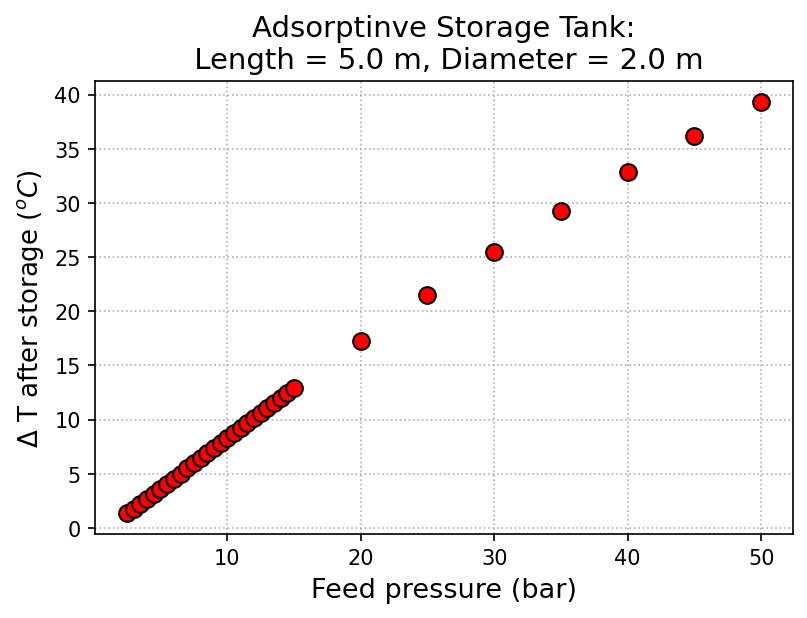

In [325]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

#plt.ylim([0, 68])
plt.grid(linestyle = ':')

# Surrogate Model

In [326]:
import scipy.optimize as optim

## Storage

In [327]:
def fn_guess(par,P):
    #T_return = par[0]*(par[1]*P)/(1+ par[1]*P) + par[2]*(par[3]*P)/(1+ par[3]*P)
    #del_m_return = par[0]*(par[1]*P**par[2])/(1+ par[1]*P**par[2])
    #del_m_return = par[0]*(par[1]*(P))/(1+ par[1]*(P))
    del_m_return = par[0]*(par[1]*(P-P_init))/(1+ par[1]*(P-P_init))
    return del_m_return 

def err_storage(par):
    #del_m_tmp = par[0]*par[1]*Pfeed_arr/(1+ par[1]*Pfeed_arr)
    del_m_tmp = fn_guess(par,Pfeed_arr[:-2])
    err = del_m_tmp - del_M_kg[:-2] / (rho_solid*L*A*(1-epsi))
    err_sq_sum = np.sum(err**2)
    return err_sq_sum
#es_opt = optim.shgo(err_storage, bounds=[[100,1000],[0,50]])
res_opt = optim.minimize(err_storage, x0 = [0.100, 10],
                        method = 'Nelder-Mead')
print(res_opt)
res_opt_M = res_opt
psol = res_opt.x
P_ran = np.linspace(1,Pfeed_arr[-1],201)
del_M_pred = fn_guess(psol, P_ran)

 final_simplex: (array([[2.67964058e+00, 1.16024493e-03],
       [2.62642461e+00, 1.18624271e-03],
       [2.63166864e+00, 1.18224715e-03]]), array([1.20925206e-05, 1.21839118e-05, 1.23234812e-05]))
           fun: 1.2092520585974145e-05
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 400
           nit: 211
        status: 1
       success: False
             x: array([2.67964058e+00, 1.16024493e-03])


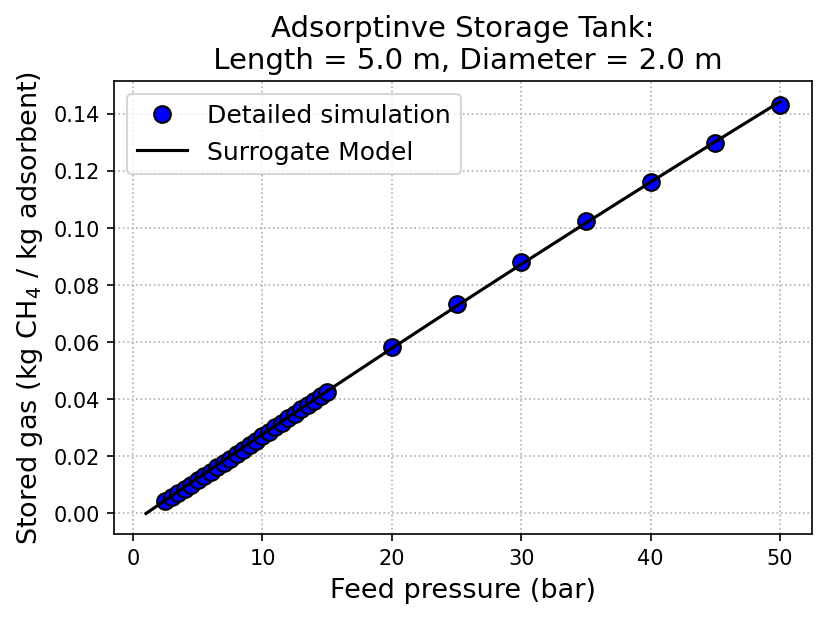

In [328]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg/ (rho_solid*L*A*(1-epsi)),
         'o', color = 'k',markersize = 8, mfc = 'b',
        label = 'Detailed simulation')
plt.plot(P_ran,del_M_pred,'k',label = 'Surrogate Model')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
#plt.ylabel('Stored gas (kg)', fontsize = 13)
plt.ylabel('Stored gas (kg CH$_{4}$ / kg adsorbent)', fontsize = 13)

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

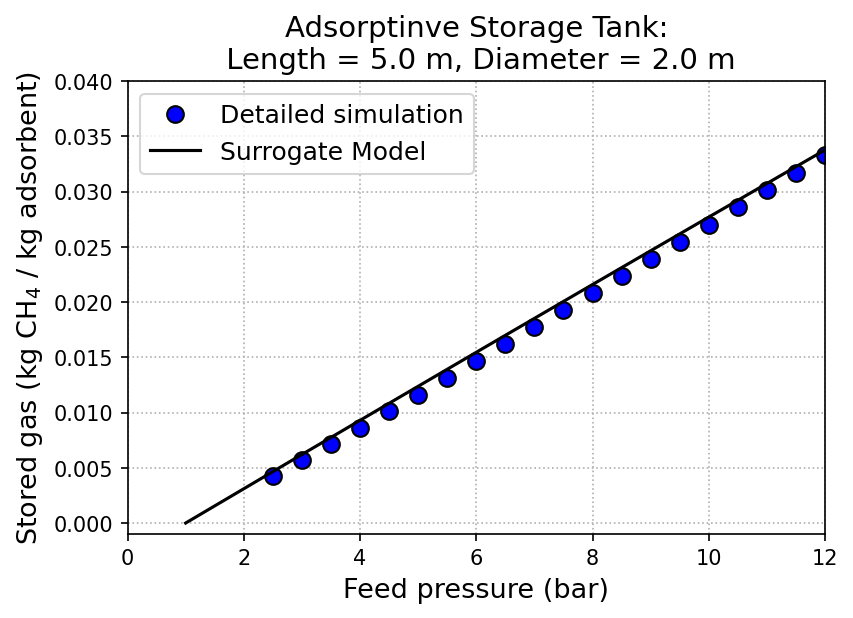

In [329]:
Mw_av = np.sum(
    np.array(feed_composition)*np.array([0.016, 0.014])) # kg/mol [CH4, N2]
del_M_kg = Mw_av*np.array(del_M_list)

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, del_M_kg / (rho_solid*L*A*(1-epsi)),
         'o', color = 'k',markersize = 8, mfc = 'b',
        label = 'Detailed simulation')
plt.plot(P_ran,del_M_pred,'k',label = 'Surrogate Model')


plt.xlabel('Feed pressure (bar)', fontsize = 13)
#plt.ylabel('Stored gas (kg)', fontsize = 13)
plt.ylabel('Stored gas (kg CH$_{4}$ / kg adsorbent)', fontsize = 13)

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)
plt.xlim(0, 12)
plt.ylim(-0.001, 0.04)
plt.grid(linestyle = ':')

## Temperture Shift

In [330]:
def fn_guess(par,P):
    #T_return = par[0]*(par[1]*P)/(1+ par[1]*P) + par[2]*(par[3]*P)/(1+ par[3]*P)
    T_return = par[0]*(par[1]*(P-P_init)**par[2])/(1+ par[1]*(P-P_init)**par[2])
    return T_return
    
def err_tempshif(par):
    #del_m_tmp = par[0]*(2*par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)/(1+ par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)
    #del_m_tmp = par[0]*(2*par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)/(1+ par[1]*Pfeed_arr+par[2]*Pfeed_arr**2)
    #del_m_tmp = par[0]*(par[1]*Pfeed_arr)/(1+ par[1]*Pfeed_arr) + par[2]*(par[3]*Pfeed_arr)/(1+ par[3]*Pfeed_arr)
    T_tmp = fn_guess(par,Pfeed_arr)
    err = T_tmp - np.array(T_fin_list)
    err_sq_sum = np.sum(err**2)
    return err_sq_sum
#res_opt = optim.shgo(err_storage, bounds=[[20,200],[0,10],[0,20],[0,100]])
res_opt = optim.minimize(err_tempshif, x0 = [113.8, 0.05, 5],
                        method = 'Nelder-Mead')
print(res_opt)
res_opt_T = res_opt
psol = res_opt.x
P_ran = np.linspace(0,Pfeed_arr[-1],111)
T_fin_pred = fn_guess(psol, P_ran)

 final_simplex: (array([[1.45421320e+02, 5.77812475e-03, 1.06990358e+00],
       [1.45421318e+02, 5.77812445e-03, 1.06990360e+00],
       [1.45421379e+02, 5.77812291e-03, 1.06990352e+00],
       [1.45421387e+02, 5.77812326e-03, 1.06990349e+00]]), array([0.01768102, 0.01768102, 0.01768102, 0.01768102]))
           fun: 0.017681022596221653
       message: 'Optimization terminated successfully.'
          nfev: 583
           nit: 328
        status: 0
       success: True
             x: array([1.45421320e+02, 5.77812475e-03, 1.06990358e+00])
<ipython-input-330-73429b6ee8ac>:3: RuntimeWarning: invalid value encountered in power
  T_return = par[0]*(par[1]*(P-P_init)**par[2])/(1+ par[1]*(P-P_init)**par[2])


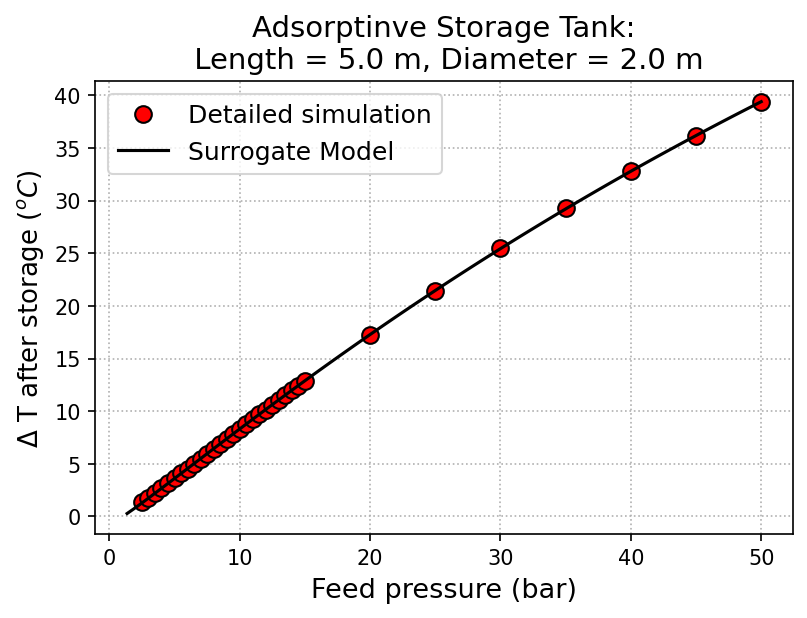

In [331]:
plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r',
        label = 'Detailed simulation')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

plt.plot(P_ran,T_fin_pred,'k',label = 'Surrogate Model')

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.grid(linestyle = ':')

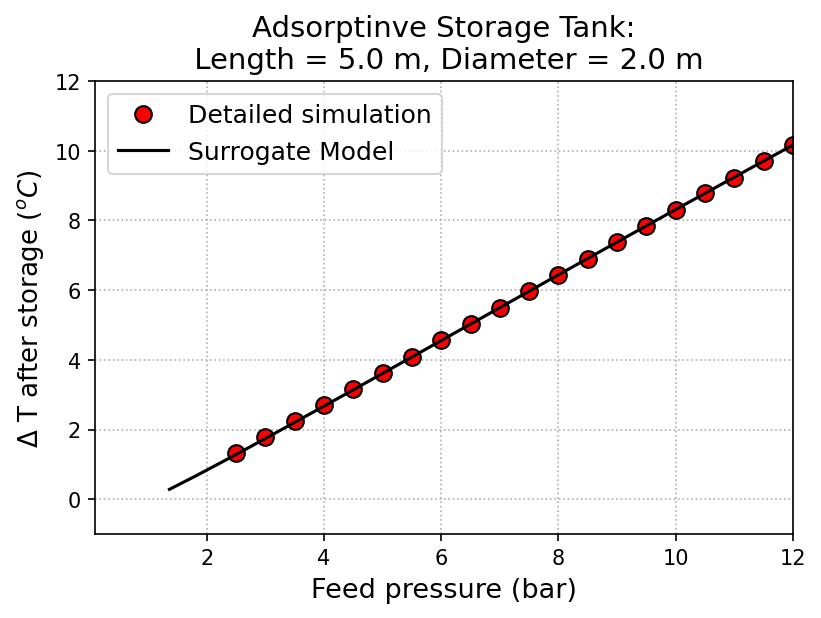

In [332]:

plt.figure(dpi = 150)
plt.plot(Pfeed_arr, T_fin_list, 
        'o', color = 'k',markersize = 8,mfc = 'r',
        label = 'Detailed simulation')

plt.xlabel('Feed pressure (bar)', fontsize = 13)
plt.ylabel('$\Delta$ T after storage ($^{o}C$)', fontsize = 12.5)

plt.plot(P_ran,T_fin_pred,'k',label = 'Surrogate Model')

plt.legend(fontsize = 12)

Leng = Design_spec['L']
Diam = np.sqrt(Design_spec['A']/3.1416)*2
plt.title('Adsorptinve Storage Tank:\n Length = {0:.1f} m, Diameter = {1:.1f} m'.format(Leng,Diam), fontsize = 14)

plt.xlim(0.1,12)
plt.ylim(-1, 12)

plt.grid(linestyle = ':')

In [333]:
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('[[Final Result: Surrogate Model]]')
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print()
print('Mass capacity:')
print('M (kg CH4 / kg adsorbent) = ')
print('k1*k2*( P - P_init ) / ( 1 + k2*( P - P_init ) )')
print()
print('[k1 , k2] = ')
print(res_opt_M.x)
print()
print()

print('Temperature difference:')
print('dT (K) = ')
print('j1*(j2*(P-P_init)**j3)/(1+ j2*(P-P_init)**j3)')
print()
print('[j1 , j2, j3] = ')
print(res_opt_T.x)
#a = input('enter any key to complete this.')


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
[[Final Result: Surrogate Model]]
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Mass capacity:
M (kg CH4 / kg adsorbent) = 
k1*k2*( P - P_init ) / ( 1 + k2*( P - P_init ) )

[k1 , k2] = 
[2.67964058e+00 1.16024493e-03]


Temperature difference:
dT (K) = 
j1*(j2*(P-P_init)**j3)/(1+ j2*(P-P_init)**j3)

[j1 , j2, j3] = 
[1.45421320e+02 5.77812475e-03 1.06990358e+00]
